In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [29]:
data = pd.read_excel("data/Clinical_and_Other_Features.xlsx", skiprows=1)
# skip the first row because it contains the units of the data
data = data[~data.index.isin([0])]
data.set_index("Patient ID", inplace=True)
# only keep the first 47 columns (everything else happens after the MRI scan)
data = data.iloc[:, :47]
data


,Days to MRI (From the Date of Diagnosis),Manufacturer,Manufacturer Model Name,Scan Options,Field Strength (Tesla),Patient Position During MRI,Image Position of Patient,Contrast Agent,Contrast Bolus Volume (mL),TR (Repetition Time),...,Bilateral Information,"If Bilateral, Different Rec Status\n{0=no 1=yes}",Side Annotated\n{L=left R=right},"Side of cancer (for the other side)\n{L=left, R=right}",Oncotype score (for the other side){##},Nottingham grade (for the other side){#},"ER (for the other side)\n{0 = neg, 1 = pos}","PR (for the other side)\n{0 = neg, 1 = pos}","HER2 (for the other side)\n{0 = neg, 1 = pos, 2=borderline}","Mol Subtype (for the other side)\n{0 = luminal-like, 1 = ER/PR pos, HER2 pos, 2 = her2,\n3 = trip neg}"
Patient ID,,,,,,,,,,,,,,,,,,,,,
Breast_MRI_001,6.0,2,0,5,1,0,-191.8003 X -176.1259 X 86.6065,1,15,4.120,...,0,NP,NP,NP,NP,NP,NP,NP,NP,NP
Breast_MRI_002,12.0,0,4,1,3,0,154.724 X 176.048 X 94.5771,1,NaN,6.918,...,0,NP,NP,NP,NP,NP,NP,NP,NP,NP
Breast_MRI_003,10.0,0,3,2,3,0,174.658 X 228.317 X 88.4878,1,NaN,5.527,...,NC,NC,NC,NC,NC,NC,NC,NC,NC,NC
Breast_MRI_004,18.0,0,4,1,1,0,188.148 X 194.282 X 94.1832,1,NaN,4.856,...,0,NP,NP,NP,NP,NP,NP,NP,NP,NP
Breast_MRI_005,12.0,2,0,5,1,1,-173.063 X -150.7869 X 59.161,1,5,4.270,...,0,NP,NP,NP,NP,NP,NP,NP,NP,NP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Breast_MRI_918,6.0,0,4,1,1,0,179.537 X 165.877 X 100,4,NaN,5.454,...,0,NP,NP,NP,NP,NP,NP,NP,NP,NP
Breast_MRI_919,24.0,0,4,1,1,0,172.595 X 192.108 X 130.246,4,NaN,5.627,...,0,NP,NP,NP,NP,NP,NP,NP,NP,NP
Breast_MRI_920,21.0,2,0,5,1,1,-173.6078 X -147.4121 X 78.5315,3,5,4.310,...,1,0,L,L,NaN,1,NP,NP,NP,NP


In [30]:
# for Image Position of Patient, break it down into x y z
data["Image Position of Patient (X)"] = data["Image Position of Patient"].str.split("X").str[0]
data["Image Position of Patient (Y)"] = data["Image Position of Patient"].str.split("X").str[1]
data["Image Position of Patient (Z)"] = data["Image Position of Patient"].str.split("X").str[2]

# data.drop(["Image Position of Patient", "Position", 'Staging(Nodes)#(Nx replaced by -1)[N]', 'Staging(Metastasis)#(Mx -replaced by -1)[M]'], axis=1, inplace=True)
data.drop(["Image Position of Patient", "Position", "ER (for the other side)\n{0 = neg, 1 = pos}", "Mol Subtype", "PR", "ER"], axis=1, inplace=True)

cont_cols = [
    'Days to MRI (From the Date of Diagnosis)', 
    'Image Position of Patient (X)', 
    'Image Position of Patient (Y)', 
    'Image Position of Patient (Z)', 
    'TR (Repetition Time)', 
    'TE (Echo Time)', 
    'Oncotype score', 
    'Oncotype score (for the other side){##}', 
    'Days to Surgery (from the date of diagnosis)', 
    'Days to local recurrence (from the date of diagnosis) ', 
    'Days to distant recurrence(from the date of diagnosis) ', 
    'Days to death (from the date of diagnosis) ', 
    'Days to last local recurrence free assessment (from the date of diagnosis) ', 
    'Days to last distant recurrence free assemssment(from the date of diagnosis) ', 
    'Age at last contact in EMR f/u(days)(from the date of diagnosis) ,last time patient known to be alive, unless age of death is reported(in such case the age of death', 
    'Age at mammo (days)', 
    'Tumor Size (cm)',
    'Date of Birth (Days)',
]

disc_cols = data.columns[~data.columns.isin(cont_cols)]
# get the number of unique values in the discrete columns sorted in descending order
data[disc_cols].nunique().sort_values(ascending=False)

FOV Computed (Field of View) in cm                                                                        24
Reconstruction Diameter                                                                                   19
Contrast Bolus Volume (mL)                                                                                18
Slice Thickness                                                                                           13
Race and Ethnicity                                                                                         9
Scan Options                                                                                               8
Acquisition Matrix                                                                                         8
Manufacturer Model Name                                                                                    8
Contrast Agent                                                                                             6
Histologic type    

In [31]:
from sklearn.preprocessing import MinMaxScaler

target_col = "HER2"
# print the rows with missing target values
print(data[data[target_col].isna()].index)
# drop rows with missing target values
data = data[~data[target_col].isna()]
disc_cols = disc_cols.drop(target_col)

# do most common value imputation for the discrete columns
for col in disc_cols:
    data[col] = data[col].fillna(data[col].mode()[0])
# do one hot encoding for the discrete columns
data = pd.get_dummies(data, columns=disc_cols)


# filter continuous columns that are in the data
cont_cols = [col for col in cont_cols if col in data.columns]
data[cont_cols] = data[cont_cols].replace(["NP", "NC"], np.nan)

# mean imputation and normalization for the numerical columns
data[cont_cols] = data[cont_cols].fillna(data[cont_cols].mean())
scaler = MinMaxScaler()
data[cont_cols] = scaler.fit_transform(data[cont_cols])

# rename target col to tumor progression
data.rename(columns={target_col: "Tumor Progression"}, inplace=True)
data = pd.get_dummies(data, columns=["Tumor Progression"])
target_cols = data.columns[data.columns.str.contains("Tumor Progression")]
print(target_cols)

data

Index([], dtype='object', name='Patient ID')
Index(['Tumor Progression_0', 'Tumor Progression_1'], dtype='object')


,Days to MRI (From the Date of Diagnosis),TR (Repetition Time),TE (Echo Time),Date of Birth (Days),Oncotype score,Oncotype score (for the other side){##},Image Position of Patient (X),Image Position of Patient (Y),Image Position of Patient (Z),Manufacturer_0,...,"HER2 (for the other side)\n{0 = neg, 1 = pos, 2=borderline}_0","HER2 (for the other side)\n{0 = neg, 1 = pos, 2=borderline}_1","HER2 (for the other side)\n{0 = neg, 1 = pos, 2=borderline}_NC","HER2 (for the other side)\n{0 = neg, 1 = pos, 2=borderline}_NP","Mol Subtype (for the other side)\n{0 = luminal-like, 1 = ER/PR pos, HER2 pos, 2 = her2,\n3 = trip neg}_0","Mol Subtype (for the other side)\n{0 = luminal-like, 1 = ER/PR pos, HER2 pos, 2 = her2,\n3 = trip neg}_1","Mol Subtype (for the other side)\n{0 = luminal-like, 1 = ER/PR pos, HER2 pos, 2 = her2,\n3 = trip neg}_NC","Mol Subtype (for the other side)\n{0 = luminal-like, 1 = ER/PR pos, HER2 pos, 2 = her2,\n3 = trip neg}_NP",Tumor Progression_0,Tumor Progression_1
Patient ID,,,,,,,,,,,,,,,,,,,,,
Breast_MRI_001,0.255952,0.150454,0.073041,0.705925,0.241581,0.5,0.068046,0.180863,0.746579,0,...,0,0,0,1,0,0,0,1,0,1
Breast_MRI_002,0.267857,0.876265,0.965471,0.752356,0.241581,0.5,0.808388,0.821749,0.765773,1,...,0,0,0,1,0,0,0,1,1,0
Breast_MRI_003,0.263889,0.515435,0.774236,0.403559,0.105263,0.5,0.850976,0.916868,0.751110,1,...,0,0,1,0,0,0,1,0,1,0
Breast_MRI_004,0.279762,0.341375,0.670651,0.452336,0.184211,0.5,0.879797,0.854931,0.764824,1,...,0,0,0,1,0,0,0,1,1,0
Breast_MRI_005,0.267857,0.189364,0.059761,0.757573,0.241581,0.5,0.108078,0.226975,0.680491,0,...,0,0,0,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Breast_MRI_918,0.255952,0.496498,0.883134,0.342973,0.241581,0.5,0.861400,0.803240,0.778831,1,...,0,0,0,1,0,0,0,1,1,0
Breast_MRI_919,0.291667,0.541375,0.899070,0.201658,0.289474,0.5,0.846569,0.850975,0.851663,1,...,0,0,0,1,0,0,0,1,1,0
Breast_MRI_920,0.285714,0.199741,0.073041,0.399232,0.118421,0.5,0.106914,0.233116,0.727135,0,...,0,0,0,1,0,0,0,1,1,0


In [49]:
# make a rf model to predict the tumor progression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

X = data.drop(target_cols, axis=1)
y = data[target_cols]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=1000, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[1]
accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred_proba, multi_class='ovr')

(0.8540540540540541, 0.6068917018284107)

In [33]:
# use recursive feature elimination, and plot a graph to see how the mse changes with the number of features
from sklearn.feature_selection import RFE
from concurrent.futures import ThreadPoolExecutor

max_features = 30

rfe = RFE(estimator=rf, n_features_to_select=max_features, step=0.005)
rfe.fit(X_train, y_train)

# get all the features in order of importance
feature_importance = X.columns[rfe.support_]
rf.fit(X_train[feature_importance], y_train)
selected_features_score = pd.Series(rf.feature_importances_, index=feature_importance).sort_values(ascending=False)
selected_features_score

Date of Birth (Days)                               0.122250
Image Position of Patient (Z)                      0.096779
Image Position of Patient (Y)                      0.093982
Days to MRI (From the Date of Diagnosis)           0.091080
Image Position of Patient (X)                      0.089648
TR (Repetition Time)                               0.074276
TE (Echo Time)                                     0.073977
Oncotype score                                     0.038783
Tumor Grade(N)\n(Nuclear)_3.0                      0.019702
Staging(Tumor Size)# [T]_2.0                       0.017305
Menopause (at diagnosis)_1                         0.016326
Tumor Location_L                                   0.016160
Staging(Nodes)#(Nx replaced by -1)[N]_1.0          0.016098
Slice Thickness _18                                0.015881
Race and Ethnicity_1                               0.015115
Staging(Metastasis)#(Mx -replaced by -1)[M]_0.0    0.015019
Tumor Grade(M)\n(Mitotic)_1.0           

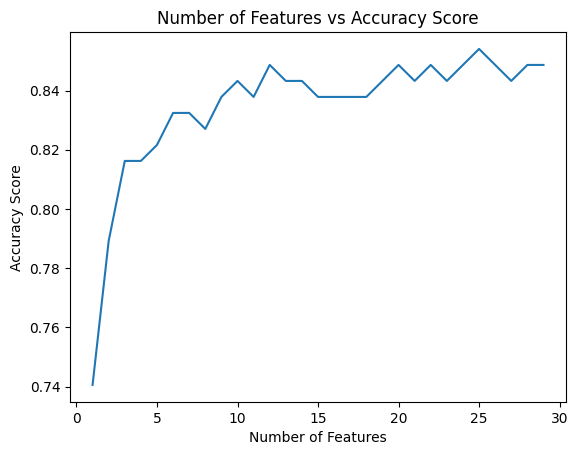

In [34]:
selected_features = selected_features_score.index
def calculate_acc(n_features):
    rf = RandomForestClassifier(n_estimators=1000, random_state=42)
    rf.fit(X_train[selected_features[:n_features]], y_train)
    y_pred = rf.predict(X_test[selected_features[:n_features]])
    return accuracy_score(y_test, y_pred)

mse = []
with ThreadPoolExecutor() as executor:
    mse = list(executor.map(calculate_acc, range(1, max_features)))

plt.plot(range(1, max_features), mse)
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Score")
plt.title("Number of Features vs Accuracy Score")
plt.show()

In [35]:
# choose features
final_features = selected_features_score.head(10).index

# display the features
final_features

Index(['Date of Birth (Days)', 'Image Position of Patient (Z)',
       'Image Position of Patient (Y)',
       'Days to MRI (From the Date of Diagnosis)',
       'Image Position of Patient (X)', 'TR (Repetition Time)',
       'TE (Echo Time)', 'Oncotype score', 'Tumor Grade(N)\n(Nuclear)_3.0',
       'Staging(Tumor Size)# [T]_2.0'],
      dtype='object')

In [36]:
# export the features and the target feature to a csv file
final_features = final_features.append(target_cols)
data[final_features].to_csv("data/cleaned.csv")

The following code takes a directory and filters out all the mri images from the first pass into another directory. 

In [22]:
import os
import re
import shutil

inputDir = r"E:\\Ramin\\NBIA\\manifest-1654812109500\\Duke-Breast-Cancer-MRI"
# outputDir = r"E:\\Ramin\\NBIA\\filtered"
outputDir = "E:\\Ramin\\NBIA\\filtered"

baseDir = "Duke-Breast-Cancer-MRI"

selectPassRegex = "Ph2|2nd|2nd Pass"

idRange = [0, 40]


for root, dirs, files in os.walk(inputDir):
    print(f"root: {root}")
    print(f"dirs: {dirs}")
    if dirs == []:
        lastFolder = root.split("\\")[-1]
        print(f"lastFolder: {lastFolder}")
        # Breast_MRI_042
        # split by "\" and select for value with Breast_MRI in it
        breastMRI = [folder for folder in root.split("\\") if "Breast_MRI" in folder][0]
        idNumber = int(breastMRI.split("_")[-1])
        print(f"breastMRI: {breastMRI}, idNumber: {idNumber}")
        if not (idNumber >= idRange[0] and idNumber <= idRange[1]):
            continue
        if re.search(selectPassRegex, lastFolder):
            print(f"folder passed: {lastFolder}")
            # copy the folder over to the output directory
            # shutil.copytree(root, os.path.join(outputDir, lastFolder))
            # folder stucture after baseDir
            folderStructure = root.split(baseDir)[1].lstrip("\\")
            print(f"folderStructure: {folderStructure}")
            outputFolder = os.path.join(outputDir, "")
            outputFolder = os.path.join(outputFolder, folderStructure)
            print(f"outputFolder: {outputFolder}")
            shutil.copytree(root, outputFolder)
            
    # for file in files:
    #     # print(file)
    #     if re.search(selectPassRegex, file):
    #         # shutil.copy(os.path.join(root, file), outputDir)
    #         print(file)

def multiProFunc(rangeLst):
    for root, dirs, files in os.walk(inputDir):
        if dirs == []:
            lastFolder = root.split("\\")[-1]
            # Breast_MRI_042
            # split by "\" and select for value with Breast_MRI in it
            breastMRI = [folder for folder in root.split("\\") if "Breast_MRI" in folder][0]
            idNumber = int(breastMRI.split("_")[-1])
            if not (idNumber >= idRange[0] and idNumber <= idRange[1]):
                continue
            if re.search(selectPassRegex, lastFolder):
                # copy the folder over to the output directory
                # shutil.copytree(root, os.path.join(outputDir, lastFolder))
                # folder stucture after baseDir
                folderStructure = root.split(baseDir)[1].lstrip("\\")
                outputFolder = os.path.join(outputDir, "")
                outputFolder = os.path.join(outputFolder, folderStructure)
                shutil.copytree(root, outputFolder)


root: E:\\Ramin\\NBIA\\manifest-1654812109500\\Duke-Breast-Cancer-MRI
dirs: ['Breast_MRI_001', 'Breast_MRI_002', 'Breast_MRI_003', 'Breast_MRI_004', 'Breast_MRI_005', 'Breast_MRI_006', 'Breast_MRI_007', 'Breast_MRI_008', 'Breast_MRI_009', 'Breast_MRI_010', 'Breast_MRI_011', 'Breast_MRI_012', 'Breast_MRI_013', 'Breast_MRI_014', 'Breast_MRI_015', 'Breast_MRI_016', 'Breast_MRI_017', 'Breast_MRI_018', 'Breast_MRI_019', 'Breast_MRI_020', 'Breast_MRI_021', 'Breast_MRI_022', 'Breast_MRI_023', 'Breast_MRI_024', 'Breast_MRI_025', 'Breast_MRI_026', 'Breast_MRI_027', 'Breast_MRI_028', 'Breast_MRI_029', 'Breast_MRI_030', 'Breast_MRI_031', 'Breast_MRI_032', 'Breast_MRI_033', 'Breast_MRI_034', 'Breast_MRI_035', 'Breast_MRI_036', 'Breast_MRI_037', 'Breast_MRI_038', 'Breast_MRI_039', 'Breast_MRI_040', 'Breast_MRI_041', 'Breast_MRI_042', 'Breast_MRI_043', 'Breast_MRI_044', 'Breast_MRI_045', 'Breast_MRI_046']
root: E:\\Ramin\\NBIA\\manifest-1654812109500\\Duke-Breast-Cancer-MRI\Breast_MRI_001
dirs: ['01